In [1]:
import pandas as pd
import numpy as np

import math

from tqdm import tqdm

from pathlib import Path
import cairosvg

from plottable import ColDef, Table
from plottable.plots import image, circled_image, bar

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap


In [2]:
def elo_win_probability(rating_teamA, rating_teamB):
    '''
        
    Notes:
        - Using 480 as the divisor as opposed to 400 because a study found it more accurately applied winnings & losings 
            - source: wikipedia Elo_rating_system (suggested modification)
    
    '''
    ## Probability of of winning of rating_teamA
    P_A = 1.0 / (1.0 + 10**((rating_teamB-rating_teamA)/480))

    ## Probability of of winning of rating_teamB
    P_B = 1.0 / (1.0 + 10**((rating_teamA-rating_teamB)/480))
    
    return(P_A, P_B)

def update_elo(winning_team_elo, losing_team_elo, win_or_tie=0, K=20 ):
    winners_chances, losers_chances = elo_win_probability(winning_team_elo, losing_team_elo)
    
    ## Values should either be 1 (Win), 0.5 (Tie), 0 (Loss)
    if win_or_tie == 1:
        new_winner_elo = winning_team_elo + K * (1 - winners_chances)
        new_loser_elo  = losing_team_elo  + K * (0 - losers_chances )
    elif win_or_tie == 0.5:
        new_winner_elo = winning_team_elo + K * (0.5 - winners_chances)
        new_loser_elo  = losing_team_elo  + K * (0.5 - losers_chances )
    else:
        print("!!! Something doesn't quite seem right when updating elo rankings !!!")
    
    return(new_winner_elo, new_loser_elo)

In [3]:
NFL_YEAR = '2024-2025'
NFL_WEEK = 15

df_elo      = pd.read_csv('../../data/cleaned/NFL_Team_Elo.csv')
df_schedule = pd.read_csv('../../data/cleaned/NFL_upcoming_schedule_cleaned.csv')
df_schedule = df_schedule.loc[(df_schedule['YEAR']==NFL_YEAR)&(df_schedule['WEEK_NUM']==NFL_WEEK), :]

## Merge the Elo data onto the schedule for both Away and Home teams
df_schedule = pd.merge(df_schedule, df_elo, how='left', left_on=['AWAY_TEAM', 'YEAR', 'WEEK_NUM'], right_on=['NFL_TEAM', 'NFL_YEAR', 'NFL_WEEK']).drop(['NFL_TEAM', 'NFL_YEAR', 'NFL_WEEK'],axis=1).rename(columns={'ELO':'AWAY_TEAM_ELO'})
df_schedule = pd.merge(df_schedule, df_elo, how='left', left_on=['HOME_TEAM', 'YEAR', 'WEEK_NUM'], right_on=['NFL_TEAM', 'NFL_YEAR', 'NFL_WEEK']).drop(['NFL_TEAM', 'NFL_YEAR', 'NFL_WEEK'],axis=1).rename(columns={'ELO':'HOME_TEAM_ELO'})

## Clean up after yourself
df_elo = None

## Drop all NaNs, which in this case are weeks that won't have Elo's just yet
df_schedule.dropna(inplace=True)

## Calculate Win Probability for both Home and Away teams
df_schedule[['AWAY_TEAM_WIN_PROB','HOME_TEAM_WIN_PROB']] = df_schedule.apply(lambda x: elo_win_probability(x.AWAY_TEAM_ELO, x.HOME_TEAM_ELO), axis=1, result_type='expand')

## Change Probability to be more readable
df_schedule['AWAY_TEAM_WIN_PROB'] = df_schedule['AWAY_TEAM_WIN_PROB'].apply(lambda x: f'{x*100:.1f} %')
df_schedule['HOME_TEAM_WIN_PROB'] = df_schedule['HOME_TEAM_WIN_PROB'].apply(lambda x: f'{x*100:.1f} %')

## Drop unneeded columns
df_schedule.drop(['YEAR'],axis=1, inplace=True)

df_schedule.head()

,WEEK_NUM,GAME_DAY_OF_WEEK,GAME_DATE,AWAY_TEAM,HOME_TEAM,GAMETIME,AWAY_TEAM_ELO,HOME_TEAM_ELO,AWAY_TEAM_WIN_PROB,HOME_TEAM_WIN_PROB
0,15,Thu,December 12,Los Angeles Rams,San Francisco 49ers,8:15 PM,1501.450605,1524.924314,47.2 %,52.8 %
1,15,Sun,December 15,Dallas Cowboys,Carolina Panthers,1:00 PM,1488.506223,1345.707334,66.5 %,33.5 %
2,15,Sun,December 15,Kansas City Chiefs,Cleveland Browns,1:00 PM,1644.369576,1426.728015,74.0 %,26.0 %
3,15,Sun,December 15,Miami Dolphins,Houston Texans,1:00 PM,1481.398999,1481.432229,50.0 %,50.0 %
4,15,Sun,December 15,New York Jets,Jacksonville Jaguars,1:00 PM,1380.460198,1408.180430,46.7 %,53.3 %


In [4]:
#### UNCOMMENT IF -- You have SVG's that you want to transform into png's
# # mapping teamnames to logo paths
# team_logo_path = Path("../../data/images/Team Logos")
# team_logo_files = list(team_logo_path.glob("*.svg"))
# team_logos_paths = {f.stem: f for f in team_logo_files}

# for path in team_logo_files:
#     path_stem = str(path.stem)
#     # print(f"{path} -> '../../data/images/Team Logos/{path_stem}.png'")
#     cairosvg.svg2png(file_obj=open(path, 'rb'), write_to=f'../../data/images/Team Logos/{path_stem}.png')

In [5]:
# mapping teamnames to logo paths
team_logo_path = Path("../../data/images/Team Logos")
team_logo_files = list(team_logo_path.glob("*.png"))
team_logos_paths = {f.stem: f for f in team_logo_files}

In [6]:
df_schedule['HOME_TEAM_LOGO'] = df_schedule['HOME_TEAM']
df_schedule['AWAY_TEAM_LOGO'] = df_schedule['AWAY_TEAM']
df_schedule["HOME_TEAM_LOGO"] = df_schedule["HOME_TEAM_LOGO"].replace(team_logos_paths)
df_schedule["AWAY_TEAM_LOGO"] = df_schedule["AWAY_TEAM_LOGO"].replace(team_logos_paths)

df_schedule['AWAY_TEAM'] = [x[-1] for x in df_schedule['AWAY_TEAM'].str.split(' ')]
df_schedule['HOME_TEAM'] = [x[-1] for x in df_schedule['HOME_TEAM'].str.split(' ')]

df_schedule['LOC'] = '@'

df_schedule['GAME_TIME'] = df_schedule['GAME_DAY_OF_WEEK'] + " " + df_schedule['GAMETIME']

df_schedule['EMPTY_COL_START'] = ''
df_schedule['EMPTY_COL_END'] = ''

unique_gametimes_idx = df_schedule.groupby('GAME_TIME').head(1).index
temp = df_schedule.iloc[unique_gametimes_idx,:].reset_index().drop('index',axis=1)
temp.index +=16

df_schedule = pd.concat([df_schedule,temp], ignore_index=False).reset_index().sort_values(['GAME_DATE','GAMETIME','index'],ascending=[True,True,False])
for col in ['WEEK_NUM', 'GAME_DAY_OF_WEEK', 'GAME_DATE', 'AWAY_TEAM','HOME_TEAM', 'GAMETIME', 'AWAY_TEAM_ELO', 'HOME_TEAM_ELO','AWAY_TEAM_WIN_PROB', 'HOME_TEAM_WIN_PROB', 'LOC']:
    df_schedule.loc[df_schedule['index']>15,col] = np.nan

df_schedule.loc[df_schedule['index']>15,['HOME_TEAM_LOGO','AWAY_TEAM_LOGO']] = '../../data/images/Team Logos/Empty.png'

table_cols = ['AWAY_TEAM_WIN_PROB', 'AWAY_TEAM','AWAY_TEAM_LOGO', 'GAME_TIME','HOME_TEAM_LOGO', 'HOME_TEAM',  'HOME_TEAM_WIN_PROB','EMPTY_COL_END']
df_schedule[table_cols].head()

,AWAY_TEAM_WIN_PROB,AWAY_TEAM,AWAY_TEAM_LOGO,GAME_TIME,HOME_TEAM_LOGO,HOME_TEAM,HOME_TEAM_WIN_PROB,EMPTY_COL_END
16,NaN,NaN,../../data/images/Team Logos/Empty.png,Thu 8:15 PM,../../data/images/Team Logos/Empty.png,NaN,NaN,
0,47.2 %,Rams,../../data/images/Team Logos/Los Angeles Rams.png,Thu 8:15 PM,../../data/images/Team Logos/San Francisco 49e...,49ers,52.8 %,
17,NaN,NaN,../../data/images/Team Logos/Empty.png,Sun 1:00 PM,../../data/images/Team Logos/Empty.png,NaN,NaN,
7,60.7 %,Bengals,../../data/images/Team Logos/Cincinnati Bengal...,Sun 1:00 PM,../../data/images/Team Logos/Tennessee Titans.png,Titans,39.3 %,
6,70.5 %,Ravens,../../data/images/Team Logos/Baltimore Ravens.png,Sun 1:00 PM,../../data/images/Team Logos/New York Giants.png,Giants,29.5 %,


In [7]:
table_col_defs = [
    ColDef("EMPTY_COL_START"    , width=0.05 , title="", textprops={"ha": "center"}) ,
    ColDef("AWAY_TEAM_WIN_PROB" , width=0.2  , title="", textprops={"ha": "right"} , formatter=lambda x: '' if pd.isna(x) else x),
    #ColDef("AWAY_TEAM_ELO"      , width=0.5 , title="", formatter="{:.0f}"),
    ColDef("AWAY_TEAM_LOGO"     , width=0.1  , title="", plot_fn=image),
    ColDef("AWAY_TEAM"          , width=0.2  , title="", textprops={"ha": "right"} , formatter=lambda x: '' if pd.isna(x) else x),
    ColDef("GAME_TIME"          , width=0.1  , title="", textprops={"ha": "center"} , formatter=lambda x: '' if pd.isna(x) else f"{x.split(' ')[0]}\n{x.split(' ')[1]}"),
    # ColDef("LOC"                , width=0.04 , title="", textprops={"ha": "center"}, formatter=lambda x: '' if pd.isna(x) else x),
    ColDef("HOME_TEAM"          , width=0.2  , title="", textprops={"ha": "left"}  , formatter=lambda x: '' if pd.isna(x) else x),
    ColDef("HOME_TEAM_LOGO"     , width=0.1  , title="", plot_fn=image),
    #ColDef("HOME_TEAM_ELO"      , width=0.5 , title="", formatter="{:.0f}"),
    ColDef("HOME_TEAM_WIN_PROB" , width=0.2  , title="", textprops={"ha": "left"}  , formatter=lambda x: '' if pd.isna(x) else x),
    ColDef("EMPTY_COL_END"      , width=0.05 , title="", textprops={"ha": "center"}) ,
]

In [8]:
team_colors = { 'background' : "#28282B",
                '49ers'      : "#AA0000",
                'Bears'      : "#C83803",
                'Bengals'    : "#FB4F14",
                'Bills'      : "#00338D",
                'Broncos'    : "#FB4F14",
                'Browns'     : "#311D00",
                'Buccaneers' : "#D50A0A",
                'Cardinals'  : "#97233F",
                'Chargers'   : "#FFC20E",
                'Chiefs'     : "#E31837",
                'Colts'      : "#002C5F",
                'Commanders' : "#5A1414",
                'Cowboys'    : "#003594",
                'Dolphins'   : "#008E97",
                'Eagles'     : "#004C54",
                'Falcons'    : "#A71930",
                'Giants'     : "#0B2265",
                'Jaguars'    : "#006778",
                'Jets'       : "#125740",
                'Lions'      : "#0076B6",
                'Packers'    : "#203731",
                'Panthers'   : "#0085CA",
                'Patriots'   : "#002244",
                'Raiders'    : "#A5ACAF",
                'Rams'       : "#FFA300",
                'Ravens'     : "#241773",
                'Saints'     : "#D3BC8D",
                'Seahawks'   : "#002244",
                'Steelers'   : "#FFB612",
                'Texans'     : "#03202F",
                'Titans'     : "#4B92DB",
                'Vikings'    : "#4F2683"}

In [9]:
def gradient_image(ax, direction=0.3, cmap_range=(0, 1), **kwargs):
    """
    Draw a gradient image based on a colormap.

    Parameters
    ----------
    ax : Axes
        The Axes to draw on.
    direction : float
        The direction of the gradient. This is a number in
        range 0 (=vertical) to 1 (=horizontal).
    cmap_range : float, float
        The fraction (cmin, cmax) of the colormap that should be
        used for the gradient, where the complete colormap is (0, 1).
    **kwargs
        Other parameters are passed on to `.Axes.imshow()`.
        In particular, *cmap*, *extent*, and *transform* may be useful.
    """
    phi = direction * np.pi / 2
    v = np.array([np.cos(phi), np.sin(phi)])
    X = np.array([[v @ [1, 0], v @ [1, 1]],
                  [v @ [0, 0], v @ [0, 1]]])
    a, b = cmap_range
    X = a + (b - a) / X.max() * X
    im = ax.imshow(X, interpolation='bicubic', clim=(0, 1),
                   aspect='auto', **kwargs)
    return (im,X)

def gradient_bar(ax, x, y, width=0.5, height=0, cmap=None):
    for left, bottom in zip(x, y):
        right = left + width
        top = bottom + height
        gradient_image( ax, direction=1,
                        extent=(left, right, bottom, top),
                        cmap=cmap)

# Python program to find the point of
# intersection of two lines

# Class used to used to store the X and Y
# coordinates of a point respectively
class Point:
	def __init__(self, x, y):
		self.x = x
		self.y = y

	# Method used to display X and Y coordinates
	# of a point
	def displayPoint(self, p):
		print(f"({p.x}, {p.y})")


def lineLineIntersection(A, B, C, D):
	# Line AB represented as a1x + b1y = c1
	a1 = B.y - A.y
	b1 = A.x - B.x
	c1 = a1*(A.x) + b1*(A.y)

	# Line CD represented as a2x + b2y = c2
	a2 = D.y - C.y
	b2 = C.x - D.x
	c2 = a2*(C.x) + b2*(C.y)

	determinant = a1*b2 - a2*b1

	if (determinant == 0):
		# The lines are parallel. This is simplified
		# by returning a pair of FLT_MAX
		return Point(10**9, 10**9)
	else:
		x = (b2*c1 - b1*c2)/determinant
		y = (a1*c2 - a2*c1)/determinant
		return Point(x, y)


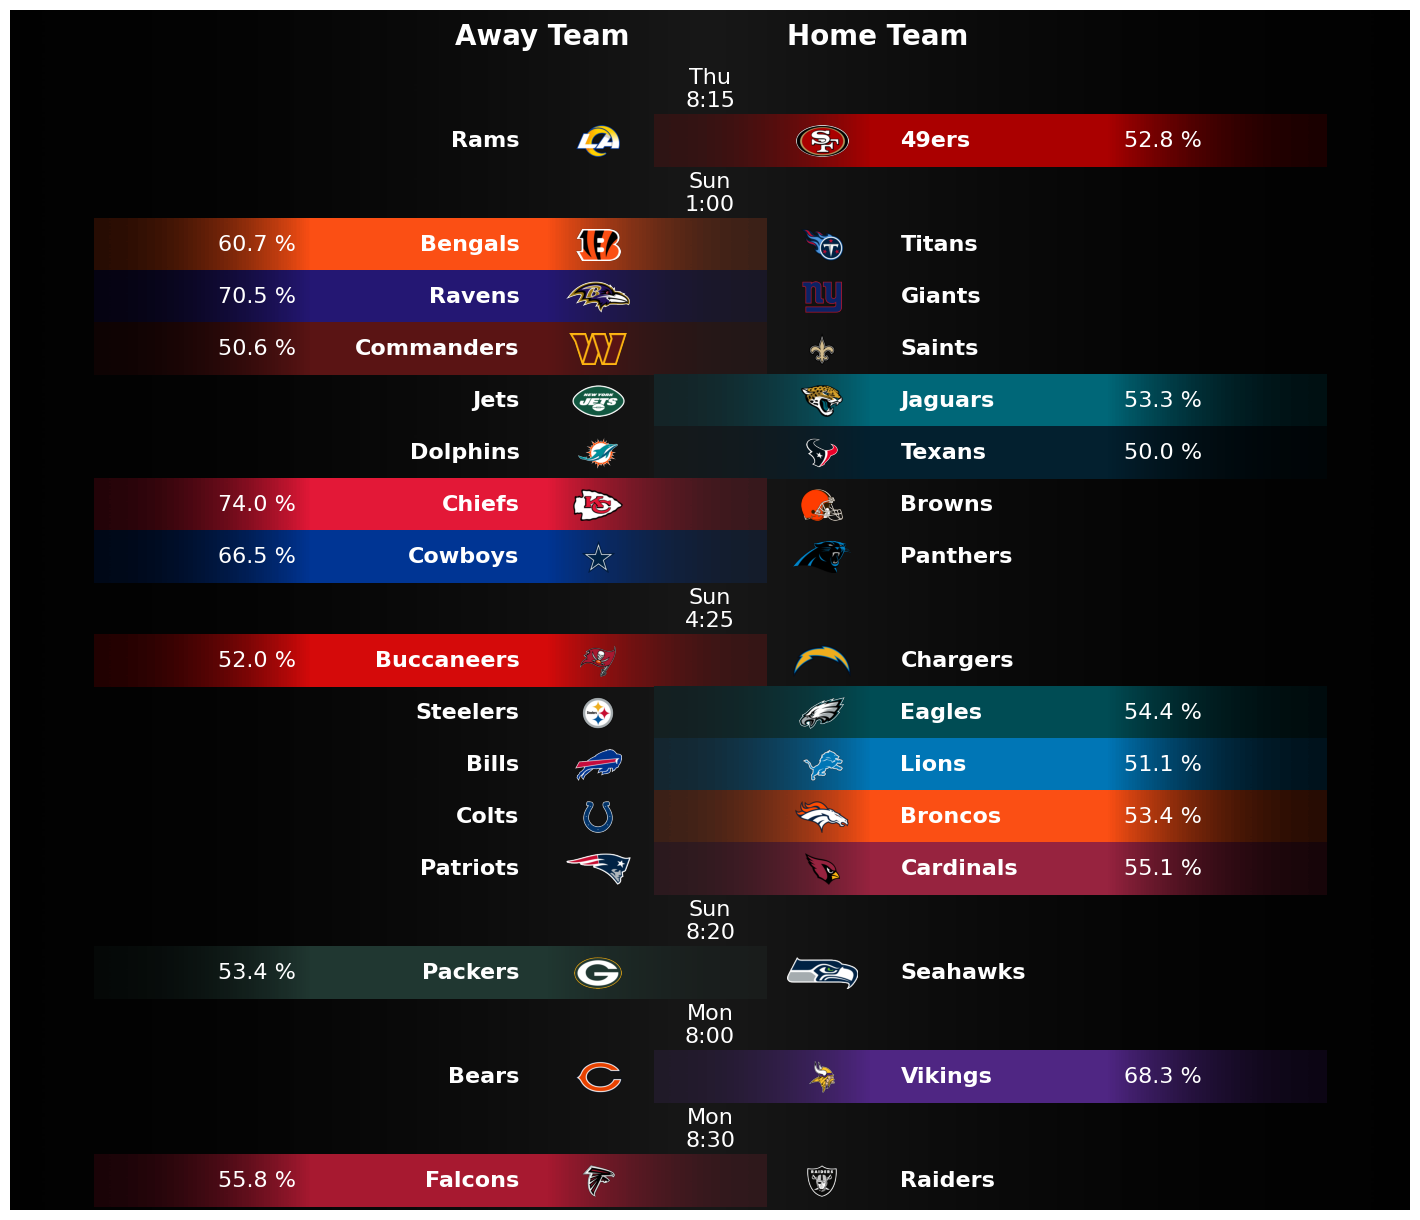

In [14]:
fig, ax = plt.subplots(figsize=(14, 12))

plt.rcParams["font.family"] = ["DejaVu Sans"]
plt.rcParams["text.color"] = 'white'

background,data = gradient_image(ax, direction=1, extent=(0, 1, 0, 1), transform=ax.transAxes,cmap=LinearSegmentedColormap.from_list("cmap_name",["black","#181818","black",]))

plt.axis('off')
plt.subplots_adjust(top = 1, right = 1, bottom = 0, left = 0)


table = Table(
    df_schedule,
    column_definitions=table_col_defs,
    row_dividers=False,
    col_label_divider=False,
    footer_divider=False,
    columns=table_cols,
    index_col="EMPTY_COL_START",
    col_label_cell_kw ={"alpha": 0.0},
    textprops={"fontsize": 16, "ha": "center"},
)


# Plot "Away team" Title 
top_row      = table.rows[0]
top_row_axis = top_row.cells[3].ax
left_most_x  = top_row.cells[2].x
bottom_y     = top_row.cells[3].y-1
height       = top_row.cells[3].height
width        = top_row.cells[2].width + top_row.cells[3].width
away_rect = Rectangle((left_most_x, bottom_y), width, height, linewidth=1)
ax.annotate( "Away Team",
            ((left_most_x+away_rect.get_width()/2.0)+.05, bottom_y+away_rect.get_height()/2.0), 
            color='w', weight='bold', fontsize=20, ha='center', va='center')

# Plot "Home team" Title
top_row      = table.rows[0]
top_row_axis = top_row.cells[5].ax
left_most_x  = top_row.cells[4].x
bottom_y     = top_row.cells[4].y-1
height       = top_row.cells[5].height
width        = top_row.cells[5].width + top_row.cells[6].width
away_rect = Rectangle((left_most_x, bottom_y), width, height, linewidth=1)
ax.annotate( "Home Team",
            ((left_most_x+away_rect.get_width()/2.0)+.05, bottom_y+away_rect.get_height()/2.0), 
            color='w', weight='bold', fontsize=20, ha='center', va='center')


unique_game_time = ''
for idx in range(len(table.rows)):

    table.rows[idx].set_alpha(0.0)
    
    table.rows[idx].cells[2].text.set_weight('bold') # Away Team Name
    table.rows[idx].cells[6].text.set_weight('bold') # Home Team Name

    row_gametime = table.rows[idx].cells[4].content
    if row_gametime != unique_game_time:
        unique_game_time = row_gametime
    else:
        table.rows[idx].cells[4].text.set_alpha(0.0)

    if not pd.isna(table.rows[idx].cells[1].content):
        away_team_prob = eval(table.rows[idx].cells[1].content[:-2])
        home_team_prob = eval(table.rows[idx].cells[7].content[:-2])
        total_dist = math.sqrt( (-0.02 - 1.46)**2 + (17 - -1)**2 )

        away_team_name = table.rows[idx].cells[2].content
        home_team_name = table.rows[idx].cells[6].content

        if away_team_prob > home_team_prob:
            ## Team name cell
            away_team_name = table.rows[idx].cells[2].content
            currentAxis = table.rows[idx].cells[3].ax
            left_most_x = table.rows[idx].cells[1].x
            bottom_y    = table.rows[idx].cells[3].y
            height      = table.rows[idx].cells[3].height
            width = 0
            for cell_idx in range(1,5):
                width += table.rows[idx].cells[cell_idx].width

            table.rows[idx].cells[7].text.set_alpha(0.0)

            gradient_bar(currentAxis,
                         np.array([left_most_x]),
                         np.array([bottom_y]),
                         width=width,
                         height=height, 
                         cmap=LinearSegmentedColormap.from_list("cmap_name",["black",team_colors[away_team_name],team_colors[away_team_name],team_colors[away_team_name],"#181818"]))

        else:
            ## Team name cell
            home_team_name = table.rows[idx].cells[6].content
            currentAxis = table.rows[idx].cells[5].ax
            left_most_x = table.rows[idx].cells[4].x
            bottom_y    = table.rows[idx].cells[4].y
            height      = table.rows[idx].cells[5].height
            width = 0
            for cell_idx in range(4,8):
                width += table.rows[idx].cells[cell_idx].width

            table.rows[idx].cells[1].text.set_alpha(0.0)

            gradient_bar(currentAxis,
                         np.array([left_most_x]),
                         np.array([bottom_y]),
                         width=width,
                         height=height, 
                         cmap=LinearSegmentedColormap.from_list("cmap_name",["black",team_colors[home_team_name],team_colors[home_team_name],team_colors[home_team_name],"#181818"]).reversed())

        # rect = Rectangle((left_most_x, bottom_y), width, height, linewidth=1, edgecolor='y', facecolor='none')
        # currentAxis.add_patch(rect)

fig.savefig(
    "test_table.png",
    facecolor=fig.get_facecolor(),
    dpi=200,
    transparent = True
)